In [1]:
#Import Modul
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")
import pandas_datareader as web
import datetime
import sklearn

In [2]:
import datetime
today = datetime.datetime.now().strftime('%d-%m-%Y')

In [3]:
df = web.DataReader('TLKM.JK', data_source='yahoo',start='01-01-2019', end=today)
print(df)

              High     Low    Open   Close       Volume    Adj Close
Date                                                                
2019-01-01  3750.0  3750.0  3750.0  3750.0          0.0  3232.642334
2019-01-02  3760.0  3700.0  3750.0  3730.0   31355300.0  3215.401611
2019-01-03  3770.0  3690.0  3710.0  3740.0   83842400.0  3224.021973
2019-01-04  3740.0  3690.0  3690.0  3710.0   73936900.0  3198.160645
2019-01-07  3790.0  3750.0  3760.0  3770.0   83678100.0  3249.883057
...            ...     ...     ...     ...          ...          ...
2022-06-08  4170.0  4080.0  4150.0  4100.0  202555900.0  4100.000000
2022-06-09  4130.0  4050.0  4080.0  4050.0  148580200.0  4050.000000
2022-06-10  4080.0  4000.0  4040.0  4020.0  189186700.0  4020.000000
2022-06-13  4100.0  3930.0  3950.0  4080.0  156054900.0  4080.000000
2022-06-14  4100.0  4020.0  4050.0  4070.0   18188700.0  4070.000000

[850 rows x 6 columns]


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 850 entries, 2019-01-01 to 2022-06-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       850 non-null    float64
 1   Low        850 non-null    float64
 2   Open       850 non-null    float64
 3   Close      850 non-null    float64
 4   Volume     850 non-null    float64
 5   Adj Close  850 non-null    float64
dtypes: float64(6)
memory usage: 46.5 KB


In [5]:
#Membuat dataframe baru
data = df.filter(['Close'])
dataset = data.values

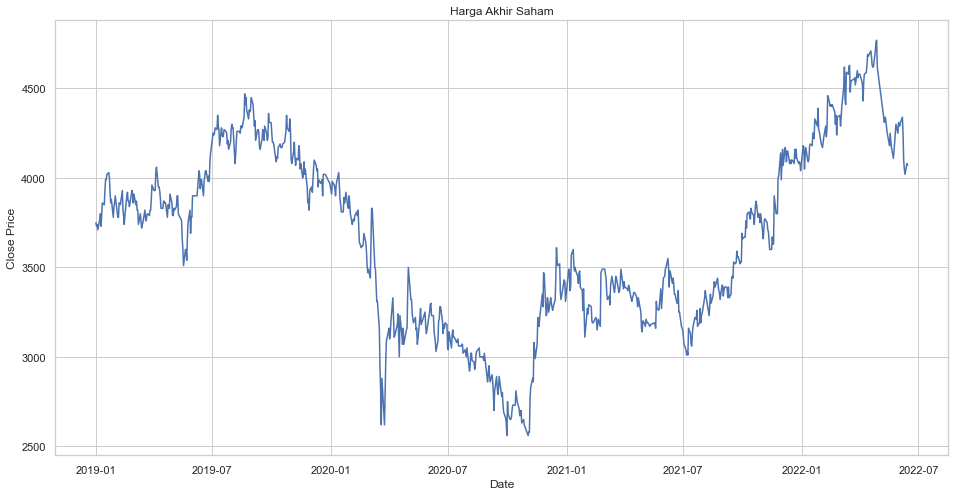

In [6]:
#Visualisasi harga akhir
plt.figure(figsize=(16,8))
plt.title('Harga Akhir Saham')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [7]:
# split data
train_size = int(len(data) * 0.70) # Menentukan banyaknya data train yaitu sebesar 70% data
train = data[:train_size]
test = data[train_size:].reset_index(drop=False)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train[['Close']])
scaler.fit(test[['Close']])

train['scaled'] = scaler.transform(train[['Close']])
test['scaled'] = scaler.transform(test[['Close']])

In [9]:
def sliding_window(data, window_size):
    sub_seq, next_values = [], []
    for i in range(len(data)-window_size):
        sub_seq.append(data[i:i+window_size])
        next_values.append(data[i+window_size])
    X = np.stack(sub_seq)
    y = np.array(next_values)
    return X,y

In [10]:
window_size = 1

X_train, y_train = sliding_window(train[['scaled']].values, window_size)
X_test, y_test = sliding_window(test[['scaled']].values, window_size)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [12]:
def create_model(LSTM_unit=128, dropout=0.5):
    # create model
    model = Sequential()
    model.add(LSTM(LSTM_unit, return_sequences=True, input_shape=(window_size,1)))
    model.add(LSTM(LSTM_unit, return_sequences=False))
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mape'])
    return model

In [13]:
LSTM_unit = [128]
dropout = [0.5]

In [14]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
# Early Stopping
es = EarlyStopping(monitor = 'val_loss', mode = "min", patience = 5, verbose = 0)

# create model
model = KerasRegressor(build_fn=create_model, epochs=100, validation_split=0.1, batch_size=30, callbacks=[es], verbose=1)

# define the grid search parameters
param_grid = dict(LSTM_unit=LSTM_unit, dropout=dropout)

In [15]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

In [16]:
grid_result = grid.fit(X_train, y_train)

Epoch 1/100
18/18 [==============================] - 4s 54ms/step - loss: 0.1071 - mape: 129818.5938 - val_loss: 0.0399 - val_mape: 131.7960
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0398 - mape: 407586.0625 - val_loss: 0.0044 - val_mape: 43.6409
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0105 - mape: 65560.1016 - val_loss: 0.0020 - val_mape: 23.2342
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0071 - mape: 54773.1289 - val_loss: 6.1093e-04 - val_mape: 10.6251
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0056 - mape: 81291.7266 - val_loss: 6.1428e-04 - val_mape: 10.6569
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0056 - mape: 64938.1367 - val_loss: 6.2279e-04 - val_mape: 11.7134
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0049 - mape: 79306.7031 - val_loss: 6.3955e-04 - val_mape: 10.6328
Epoch 8/100
1

In [17]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Mengambil model terbaik
best_model = grid_result.best_estimator_.model

Best: -0.001727 using {'LSTM_unit': 128, 'dropout': 0.5}
-0.001727 (0.000697) with: {'LSTM_unit': 128, 'dropout': 0.5}


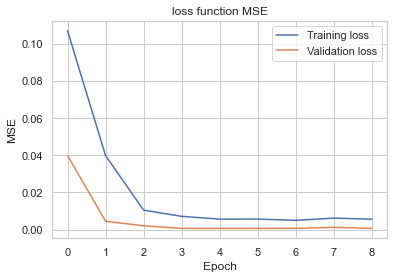

In [18]:
history = best_model.history
# grafik loss function MSE

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('loss function MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()

In [19]:
# Prediksi data train
predict_train = scaler.inverse_transform(best_model.predict(X_train))
true_train = scaler.inverse_transform(y_train)

# Prediksi data test
predict_test = scaler.inverse_transform(best_model.predict(X_test))
true_test = scaler.inverse_transform(y_test)

<AxesSubplot:xlabel='Date', ylabel='Close'>

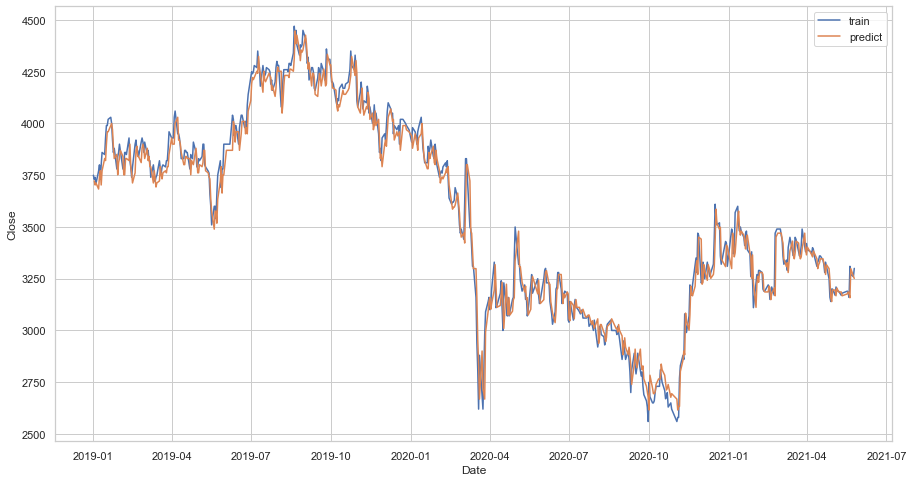

In [20]:
train['predict'] = np.nan
train['predict'][-len(predict_train):] = predict_train[:,0]

plt.figure(figsize=(15,8))
sns.lineplot(data=train, x='Date', y='Close', label = 'train')
sns.lineplot(data=train, x='Date', y='predict', label = 'predict')

In [21]:
print(f"MSE Data Test : {sklearn.metrics.mean_squared_error(predict_test, true_test)}")
print(f"RMSE Data Test :{np.sqrt(np.mean(predict_test - true_test)**2)}")
print(f"MSE Data Train : {sklearn.metrics.mean_squared_error(predict_train, true_train)}")
print(f"RMSE Data Train : {np.sqrt(np.mean(predict_train - true_train)**2)}")

MSE Data Test : 5216.290165972755
RMSE Data Test :23.648494209830194
MSE Data Train : 5138.373880968353
RMSE Data Train : 13.016194661458325


<AxesSubplot:xlabel='Date', ylabel='Close'>

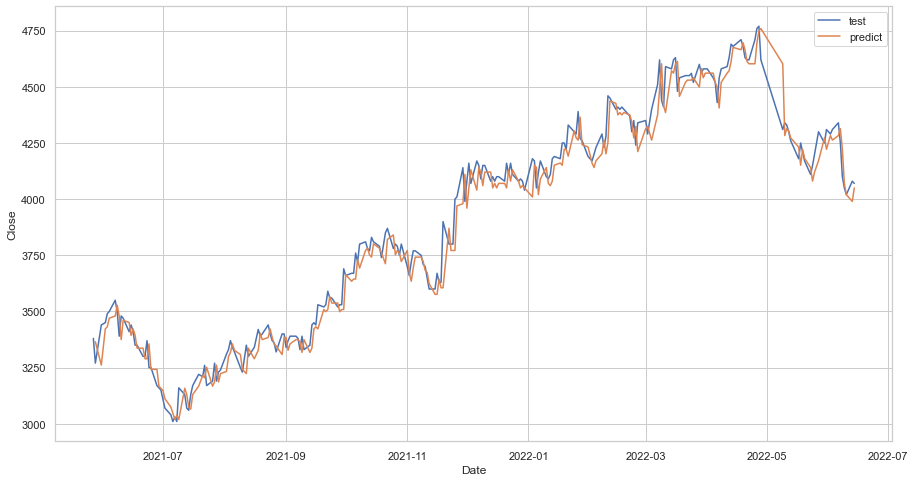

In [22]:
test['predict'] = np.nan
test['predict'][-len(predict_test):] = predict_test[:,0]

plt.figure(figsize=(15,8))
sns.lineplot(data=test, x='Date', y='Close', label = 'test')
sns.lineplot(data=test, x='Date', y='predict', label = 'predict')

<AxesSubplot:xlabel='Date', ylabel='Close'>

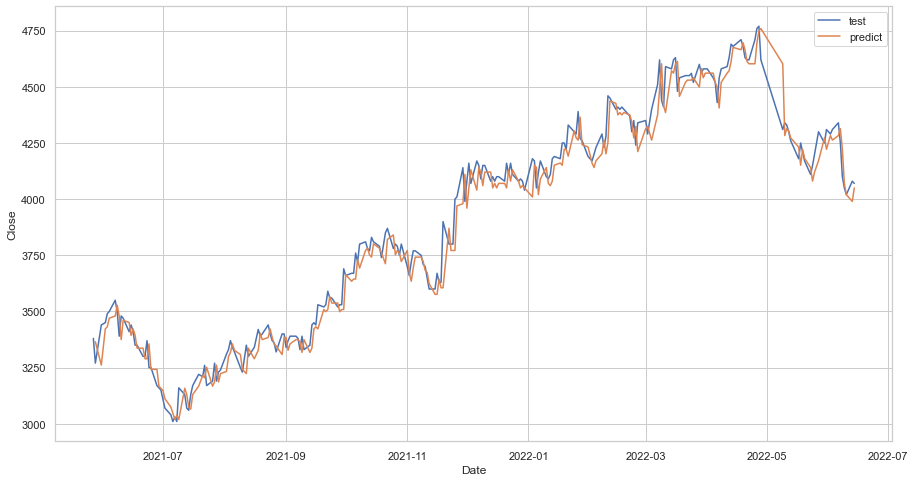

In [23]:
plt.figure(figsize=(15,8))
sns.lineplot(data=test[-365:], x='Date', y='Close', label = 'test')
sns.lineplot(data=test[-365:], x='Date', y='predict', label = 'predict')

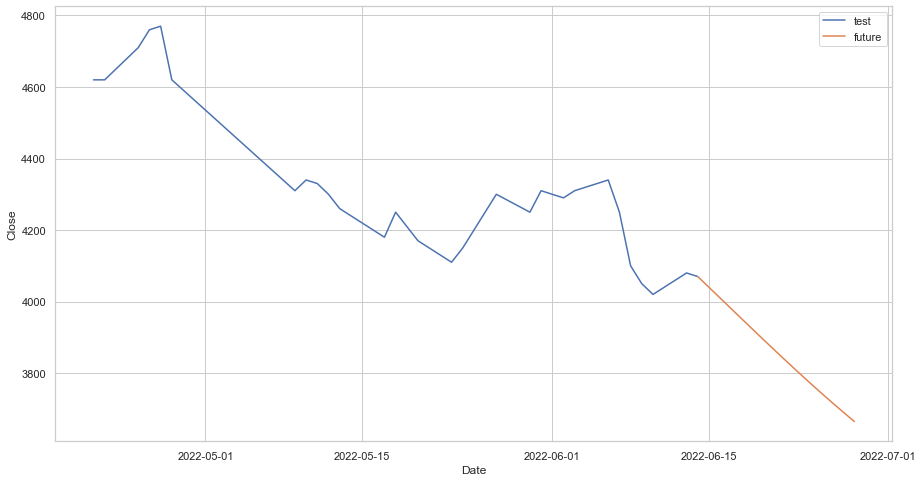

In [24]:
# forecasting data selanjutnya
y_test = scaler.transform(test[['Close']])
n_future = 2*7
future = [[y_test[-1,0]]]
X_new = y_test[-window_size:,0].tolist()

for i in range(n_future):
    y_future = best_model.predict(np.array([X_new]).reshape(1,window_size,1))
    future.append([y_future[0,0]])
    X_new = X_new[1:]
    X_new.append(y_future[0,0])

future = scaler.inverse_transform(np.array(future))
date_future = pd.date_range(start=test['Date'].values[-1], periods=n_future+1, freq='D')
# Plot Data sebulan terakhir dan seminggu ke depan
plt.figure(figsize=(15,8))
sns.lineplot(data=test[-1*30:], x='Date', y='Close', label = 'test')
sns.lineplot(x=date_future, y=future[:,0], label = 'future')
plt.ylabel('Close');


In [25]:
A = future[0:].ravel().tolist()
print(A)

[4070.0, 4040.011081695556, 4009.9232006072993, 3979.8010158538814, 3949.7104072570796, 3919.7181987762447, 3889.8901128768916, 3860.2921342849727, 3830.9883594512935, 3802.041363716125, 3773.5112571716304, 3745.4551076889034, 3717.926521301269, 3690.97532749176, 3664.6471595764156]


In [26]:
#untuk program akhir di buat dulu list data future di tambah dengan data asli index -1, kemudian menggunakan while loop dan ambil hasil akhirnya

In [27]:
G = test['Close']
B = G[-1:].tolist()
B

[4070.0]

In [28]:
B.extend(A)
B

[4070.0,
 4070.0,
 4040.011081695556,
 4009.9232006072993,
 3979.8010158538814,
 3949.7104072570796,
 3919.7181987762447,
 3889.8901128768916,
 3860.2921342849727,
 3830.9883594512935,
 3802.041363716125,
 3773.5112571716304,
 3745.4551076889034,
 3717.926521301269,
 3690.97532749176,
 3664.6471595764156]

In [39]:
def my_return (n=100000):
    i = 1
    while i < len(B):
        n = 100*(B[i] - B[i-1])+n
        print(n)
        i = i+1